# WSI - ćwiczenie 4
*Tomasz Żebrowski*

Celem zadania była implementacja drzew decyzyjnych oraz algorytmu ID3 do ich budowania. Moją realizacja znajduje się w pliku `tree.py`. Jego istotne elementy to:
- `DecisionTree` - klasa reprezentująca drzewo decyzyjne. Konstruktor przyjmuje parametr opcjonalny `max_depth`, który ogranicza maksymalny rozmiar drzewa. Jego domyślną wartością jest 5. Klasa posiada następujące metody:
    - `fit(X, y)` - Z wykorzystaniem algorytmu ID3 buduje strukturę drzewa decyzyjnego dla zbioru uczącego `X` o etykietach `y`.
    - `predict(X)` - Wyznacza predykcje dla serii próbek `X`, korzystając z wyznaczonej struktury drzewa. Zwraca serię predykcji.

- `ID3` - funckja realizująca algorytm ID3. Jako parametry przyjmuje między innymi:
    - `Y` - listę wszystkich etykiet w danych uczących
    - `D` - zbiór parametrów uczących
    - `X` - wartości parametrów w zbiorze uczącym
    - `y` - etykiety w zbiorze uczącym
    - `depth` - aktualną głębokość drzewa.

### Przygotowanie danych
Przed wykorzystaniem algorytmu, konieczne jest pozyskanie i odpowiednie przygotowanie danych. Rozpoczynam od pobrania bazy, na której ma być testowany algorytm. Po ich zapisaniu w pliku `breast-cancer.data`, wykorzystuję poniższy kod aby je wczytać. Dodatkowo, wyświetlam kilka pierwszych rekordów - z czystej ciekawości oraz by zweryfikować poprawność wczytywania.

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv('breast-cancer.data', header=0) 
data.head().T

,0,1,2,3,4
class,no-recurrence-events,no-recurrence-events,no-recurrence-events,no-recurrence-events,no-recurrence-events
age,30-39,40-49,40-49,60-69,40-49
menopause,premeno,premeno,premeno,ge40,premeno
tumor-size,30-34,20-24,20-24,15-19,0-4
inv-nodes,0-2,0-2,0-2,0-2,0-2
node-caps,no,no,no,no,no
deg-malig,3,2,2,2,2
breast,left,right,left,right,right
breast-quad,left_low,right_up,left_low,left_up,right_low
irradiat,no,no,no,no,no


Ponieważ wszystko wygląda poprawnie, przechodzę do następnego kroku. W poniższych liniach dzielę dane na tabelę `X` - wartości parametrów uczących oraz listę `y` - klasy odpowiednich rekordów.

In [5]:
feature_cols = ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad']
X = data.loc[:, feature_cols]
y = data.loc[:, 'irradiat']

Następnie dzielę dane na zbiory: uczący, walidacyjny i testowy (odpowiednio train, val i test). Wykorzystuję do tego funkcję `sklearn.model_selection.train_test_split`.

In [11]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)

Poniżej wypisuję liczność uzyskanych zbiorów.

In [125]:
counts = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]
print("Liczność zbioru treningowego:\t", counts[0])
print("Liczność zbioru walidacyjnego:\t", counts[1])
print("Liczność zbioru testowego:\t", counts[2])

Liczność zbioru treningowego:	 160
Liczność zbioru walidacyjnego:	 54
Liczność zbioru testowego:	 72


Widać, że zbiory te są bardzo małe. To niedobrze - wytrenowanie klasyfikatora na małym zbiorze danych uczących nie jest łatwe. Co więcej, walidacja może okazać się niezbyt dobra w wyniku małego rozmiaru zbioru walidacyjnego.

### Wykorzystanie drzewa decyzyjnego
Tak przygotowane dane można już wykorzystać do budowy drzewa decyzyjnego

Poniższy kod używa mojej implementacji z pliku `tree.py` aby stworzyć i zbudować drzewo decyzyjne dla omawianego zbioru danych.

In [126]:
from tree import DecisionTree

tree = DecisionTree()
tree.fit(X_train, y_train)

Drzewo jest gotowe. Warto w tym momencie sprawdzić czy ono działa. W tym celu używam go na przykładowym elemencie zbioru walidacyjnego.

In [127]:
y_pred = tree.predict(X_val.iloc[42:43])
print("Predykcja modelu: ", end="")
print(y_pred.iloc[0])
print("Wartość prawdziwa: ", end="")
print(y_val.iloc[42])

Predykcja modelu: no
Wartość prawdziwa: no


Model nie stwierdził obecności raka. Okazuje się to być zgodne z prawdą. Poniższy kod wykonuje podobny eksperyment dla wszystkich elementów zbioru walidacyjnego i wypisuje jaką część wszystkich predykcji model wykonał poprawnie.

In [128]:
y_val_pred = tree.predict(X_val)
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(y_val_pred)):
    if y_val_pred.iloc[i] == y_val.iloc[i]:
        if y_val_pred.iloc[i] == "yes":
            tp += 1
        else:
            tn += 1
    else:
        if y_val_pred.iloc[i] == "yes":
            fp += 1
        else:
            fn += 1

total = len(y_val_pred)
good_score = (tp+tn) / total
print("Trafienia:")
print('{0:.2f}'.format(good_score*100) + '%')

Trafienia:
85.19%


Niestety, uzyskany sukces jest prawdopodobnie pozorny. Wynika to z tego, że klasa negatywna jest w zbiorze walidacyjnym znacznie liczniejsza od klasy pozytywnej. W takiej sytuacji możliwe jest, że nawet klasyfikator zwracający zawsze klasę negatywną uzyska dobry wynik liczony w taki sposób.

In [129]:
y_val_count = y_val.value_counts()
print(int(y_val_count["no"] / (y_val_count["no"] + y_val_count["yes"])*10000)/100, "%")

75.92 %


Okazuje się, że taki klasyfikator jest prawie tak dobry jak moje drzewo decyzyjne! (Oczywiście tylko pod kątem wyniku liczonego w taki sposób)

Aby móc ocenić realną jakość klasyfikatora, konieczne będzie zastosowanie innej metryki. Rozpoczynam od wpisania wyników eksperymentu do tabeli (macierzy pomyłek) w opisany poniżej sposób.

In [130]:

confusion_matrix_raw = np.array([[tn, fp], 
                             [fn, tp]])
confusion_matrix = pd.DataFrame({"Negative": [tn, fp],
                                 "Positive": [fn, tp]},
                                 index=["Negative", "Positive"])
confusion_matrix.head().T

,Negative,Positive
Negative,39,2
Positive,6,7


Wiersze tabeli to wartości prawdziwe, kolumny to wartości przewidziane. Wartości w tabeli to liczność zbioru.

Widać, że poprzednia metryka oceniała drzewo decyzyjne zbyt optymistycznie. Na macierzy pomyłek widać, że jedynie 7 z 13 wszystkich prawdziwie pozytywnych wyników zostało sklasyfikowanych jako poytywne. Sytuacja wygląda nieco lepiej jeśli spojrzymy jaka część wyników zgłoszonych jako pozytywne była prawdziwie klasą pozytywną. W tym przypadku jest to 7 z 9.

Taki sposób rozumowania wykorzystuje się licząc dla klasyfikatora wynik *precyzji* i *czułości*. Wyrażają one wyznaczone eksperymentalnie prawdopodobieństwa, że, odpowiednio, zgłoszony wynik pozytywny jest faktycznie pozytywny, oraz że wynik prawdziwie pozytywny zostanie zgłoszony jako pozytywny.

W przypadku omawianego zadania, *precyzja* to prawdopodobieństwo, że pacjent zdiagnozowany jako nosiciel choroby będzie faktycznie chory, natomiast *czułość* jest prawdopodobieństwem, że chory pacjent zostanie zdiagnozowany.

Dodatkowo, liczę normę *F1*, będącą formą uśrednienia poprzednich.

In [131]:

print("Precyzja:\t", '{0:.4f}'.format(tp/(tp+fp)))
print("Czułość:\t", '{0:.4f}'.format(tp/(tp+fn)))
print("F1:\t\t", '{0:.4f}'.format(tp/(tp + (fn + fp)/2)))

Precyzja:	 0.7778
Czułość:	 0.5385
F1:		 0.6364


Widać, że wyniki nie są zatrważająco złe - klasyfikator radzi sobie dość przyzwoicie. Problemem może być to, że czułość jest niska - kiedy diagnozujemy chorobe często wolelibyśmy mieć pewność, że nie przeoczymy chorego pacjenta, nawet kosztem pozytywnej diagnozy osoby zdrowej. W tym przypadku jest odwrotnie - precyzja wyższa od czułości oznacza, że pacjent zdiagnozowany jest najprawdopodobniej rzeczywiście chory, ale jest duża szansa na przeoczenie niektórych chorych.

### Jakość modelu w zależności od rozmiaru drzewa

Powyższy eksperyment został przeprowadzony dla drzewa o domyślnym ograniczeniu `max_depth=5`. Możliwe jednak, że inne jego wartości dadzą lepszy model. Aby zbadać zależność jakości klasyfikatora od rozmiaru drzewa, wyznaczam *F1* dla drzew o różnych głębokościach zarówno na zbiorze walidacyjnym, jak i uczącym.

In [1]:
def precision_recall_f1(tree, X, y):
    y_pred = tree.predict(X)
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(y_pred)):
        if y_pred.iloc[i] == y.iloc[i]:
            if y_pred.iloc[i] == "yes":
                tp += 1
            else:
                tn += 1
        else:
            if y_pred.iloc[i] == "yes":
                fp += 1
            else:
                fn += 1
    total = len(y_pred)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = tp/(tp + (fn + fp)/2)
    return precision, recall, f1

In [143]:
result = {}
for i in range(1, 10):
    result[i] = {}
    result[i]["val"] = {}
    result[i]["train"] = {}
    tree = DecisionTree(max_depth=i)
    tree.fit(X_train, y_train)
    precision, recall, f1 = precision_recall_f1(tree, X_val, y_val)
    result[i]["val"]["precision"] = precision
    result[i]["val"]["recall"] = recall
    result[i]["val"]["f1"] = f1
    precision, recall, f1 = precision_recall_f1(tree, X_train, y_train)
    result[i]["train"]["precision"] = precision
    result[i]["train"]["recall"] = recall
    result[i]["train"]["f1"] = f1


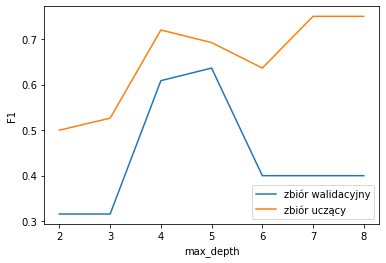

In [137]:
import matplotlib.pyplot as plt
plt.plot(list(result.keys())[1:-1], [result[i]["val"]["f1"] for i in result.keys()][1:-1], label="zbiór walidacyjny")
plt.plot(list(result.keys())[1:-1], [result[i]["train"]["f1"] for i in result.keys()][1:-1], label="zbiór uczący")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.legend()
plt.show()


Po pierwsze, widać wyraźnie, że drzewa radzą sobie lepiej kiedy testujemy je na danych uczących. Nie ma w tym nic dziwnego, ponieważ są to te same dane, na podstawie których struktura drzew była budowana.

Na początku widać, że wynik klasyfikatorów wzrasta wraz ze wzrostem ich głębokości dla obu zbiorów. Powyżej `max_depth=5` jakość dla zbioru walidacyjnego zaczyna dość gwałtownie spadać i ustala się na niskiej wartości do końca eksperymentu, podczas gdy jakość dla zbioru uczącego dalej wzrasta. Pokazuje to, że modele o głębokości >5 są przeuczone - zbytnio dostosowują się do zbioru uczącego, tracąc tym samym zdolność ekstrapolacji na nowe dane.

Na podstawie powyższego eksperymentu stwierdzam, że dla metryki *F1* model działa najlepiej przy `max_depth=5` (nie bez powodu jest to domyślna wartość tego parametru).

### Precyzja/Czułość w zależności od rozmiaru drzewa

Nie jestem w pełni przekonany do wyznaczonego klasyfikatora. Ponieważ dla omawianego problemu istotna jest wysoka czułość modelu, sprawdzam czy może dla pewnych wartości parametru `max_depth` jest ona większa od precyzji.

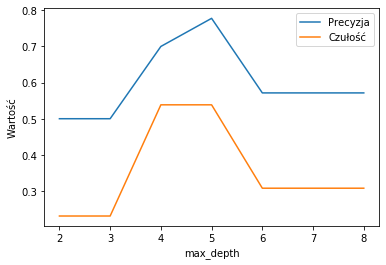

In [138]:
plt.plot(list(result.keys())[1:-1], [result[i]["val"]["precision"] for i in result.keys()][1:-1], label="Precyzja")
plt.plot(list(result.keys())[1:-1], [result[i]["val"]["recall"] for i in result.keys()][1:-1], label="Czułość")
plt.xlabel("max_depth")
plt.ylabel("Wartość")
plt.legend()
plt.show()

Niestety, okazuje się, że w przypadku tego problemu, Precyzja i czułość są skorelowane i precyzja będzie zawsze wyższa od czułości

### Wyznaczenie jakości modelu na zbiorze testowym

Zdecydowałem się już na konkretny model. W tym wypadku wyznaczam jego spodziewaną jakość na podstawie zbioru testowego.

In [18]:
tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)
precision, recall, f1 = precision_recall_f1(tree, X_test, y_test)
print("Precyzja:\t", '{0:.4f}'.format(precision))
print("Czułość:\t", '{0:.4f}'.format(recall))
print("F1:\t\t", '{0:.4f}'.format(f1))

Precyzja:	 0.5882
Czułość:	 0.4000
F1:		 0.4762


Niestety, klasyfikator działa słabo. Na podstawie danych testowych założyć można, że pacjent zdiagnozowany pozytywnie przez model jest naprawdę chory z prawdopodobieństwem ok. 59%, a chorzy pacjenci będą diagnozowani z prawdopodobieństwem 40%. Wyniki są słabe.

Główną przyczyną jest w tym przypadku niska liczność zbiorów danych. Mało liczny zbiór uczący sprawia, że model niekoniecznie nauczy się prawidłowo interpretować relacje między parametrami, czyli będzie słabo ekstrapolował swoją wiedzę na nowe dane. Dużym problemem w tym przypadku jest również bardzo mała liczność zbioru walidacyjnego - jakość modelu oceniał na bardzo małym zbiorze przykładów walidacyjnych, a takie testowanie może być mylące. W tym miejscu sam dobiłe sobie gwóźdź do trumny - losowałem podziały na zbiory uczący i walidacyjny tak długo, aż dostałem dobry wynik walidacji. Jest to oczywiście bardzo zła praktyka - taki wynik walidacji (jak się z resztą okazało) nie powtórzy się dla danych testowych ani kiedy model będzie wykorzystywany dla prawdziwych danych.

Liczność zbioru testowego jest również niewielka - ze względu na to istnieje szansa, że model jest dobry, ale wylosowana próbka testowa była szczególnie niesprzyjająca. Jest to sytuacja bardzo podobna do optymistycznej walidacji przy zbyt małym zbiorze walidacyjnym - akurat takie dane się wylosowały. Oczywiście taka opcja nie jest powodem do optymizmu - możliwe jest przecież również, że dane testowe sprzyjały modelowi, ale ten jest po prostu niezwykle beznadziejny (co na szczęście jest raczej mniej prawdopodobne w tym przypadku).

Z czystej ciekawości - by uzmysłowić sobie jak losowość podziału na zbiory uczący, walidacyjny i testowy wpływa na uzyskane wyniki, wyznaczam *F1* na każdym ze zbiorów dla kilku losowych podziałów.

In [32]:
for i in range(3):
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)
    tree = DecisionTree(max_depth=5)
    tree.fit(X_train, y_train)
    precision, recall, f1 = precision_recall_f1(tree, X_test, y_test)
    print(f"\nPróba {i+1}")
    print("Precyzja:\t", '{0:.4f}'.format(precision))
    print("Czułość:\t", '{0:.4f}'.format(recall))
    print("F1:\t\t", '{0:.4f}'.format(f1))


Próba 1
Precyzja:	 0.3600
Czułość:	 0.5294
F1:		 0.4286

Próba 2
Precyzja:	 0.6667
Czułość:	 0.3333
F1:		 0.4444

Próba 3
Precyzja:	 0.4762
Czułość:	 0.5000
F1:		 0.4878


Widać, że wyniki dla kilku przykładów są bardzo różne. Czase, precyzja jest znacznie większa, czasem czułość. Aby jednak móc wyciągnąć wnioski, powtarzam eksperyment wiele razy.

In [45]:
results = {}
results["val"] = {}
results["train"] = {}
results["test"] = {}
for key in results.keys():
    results[key]["precision"] = []
    results[key]["recall"] = []
    results[key]["f1"] = []
for i in range(1000):
    try:
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y)
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)
        tree = DecisionTree(max_depth=5)
        tree.fit(X_train, y_train)
        precision, recall, f1 = precision_recall_f1(tree, X_test, y_test)
        results["test"]["precision"].append(precision)
        results["test"]["recall"].append(recall)
        results["test"]["f1"].append(f1)
        precision, recall, f1 = precision_recall_f1(tree, X_val, y_val)
        results["val"]["precision"].append(precision)
        results["val"]["recall"].append(recall)
        results["val"]["f1"].append(f1)
        precision, recall, f1 = precision_recall_f1(tree, X_train, y_train)
        results["train"]["precision"].append(precision)
        results["train"]["recall"].append(recall)
        results["train"]["f1"].append(f1)
    except ZeroDivisionError:
        pass

In [50]:
mean_std = {}
for key in results.keys():
    mean_std[key] = {}
    for metric in results[key].keys():
        mean_std[key][metric] = {}
        mean_std[key][metric]["mean"] = np.mean(results[key][metric])
        mean_std[key][metric]["std"] = np.std(results[key][metric])

print("Precyzja na zbiorze testowym:\t", '{0:.4f}'.format(mean_std["test"]["precision"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["test"]["precision"]["std"]))
print("Czułość na zbiorze testowym:\t", '{0:.4f}'.format(mean_std["test"]["recall"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["test"]["recall"]["std"]))
print("F1 na zbiorze testowym:\t\t", '{0:.4f}'.format(mean_std["test"]["f1"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["test"]["f1"]["std"]))
print("\n")
print("Precyzja na zbiorze walidacyjnym:\t", '{0:.4f}'.format(mean_std["val"]["precision"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["val"]["precision"]["std"]))
print("Czułość na zbiorze walidacyjnym:\t", '{0:.4f}'.format(mean_std["val"]["recall"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["val"]["recall"]["std"]))
print("F1 na zbiorze walidacyjnym:\t\t", '{0:.4f}'.format(mean_std["val"]["f1"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["val"]["f1"]["std"]))
print("\n")
print("Precyzja na zbiorze uczącym:\t", '{0:.4f}'.format(mean_std["train"]["precision"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["train"]["precision"]["std"]))
print("Czułość na zbiorze uczącym:\t", '{0:.4f}'.format(mean_std["train"]["recall"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["train"]["recall"]["std"]))
print("F1 na zbiorze uczącym:\t\t", '{0:.4f}'.format(mean_std["train"]["f1"]["mean"]), "+/-", '{0:.4f}'.format(mean_std["train"]["f1"]["std"]))

Precyzja na zbiorze testowym:	 0.4742 +/- 0.2095
Czułość na zbiorze testowym:	 0.2772 +/- 0.1862
F1 na zbiorze testowym:		 0.3110 +/- 0.1610


Precyzja na zbiorze walidacyjnym:	 0.4759 +/- 0.2450
Czułość na zbiorze walidacyjnym:	 0.2778 +/- 0.1848
F1 na zbiorze walidacyjnym:		 0.3105 +/- 0.1636


Precyzja na zbiorze uczącym:	 0.7013 +/- 0.1123
Czułość na zbiorze uczącym:	 0.4619 +/- 0.1939
F1 na zbiorze uczącym:		 0.5177 +/- 0.1302


Powyższe wyniki wyznaczone są dla 1000 losowych podziałów danych.

Widać, że odchylenia wyników są bardzo duże - rzeczywiście na jakość modelu i jego oceny wpływa podział danych na zbiory (trudno tego uniknąć, gdy pracuje się na tak małych zbiorach). Obserwacja ta potwierdza poprawność moich poprzednich wniosków.

Widać, że wyniki dla zbioru uczącego są znacznie wyższe niż dla testowego i walidacyjnego, co jest zgodne z oczekiwaniami. Można również zauważyć, że średnie wyniki dla zbioru walidacyjnego i testowego bardzo zbliżyły się do siebie - tak powinno być (w sytuacji idealnej wynik na zbiorze walidacyjnym dokładnie odzwierciedla to, co wyszło by na zbiorze testowym). Idąc dalej, można się spodziewać, że również wyznaczone wyniki dla zbioru testowego są bliskie prawdzie i sprawdziłyby się na nowych danych.